# Samplot for SVs from GMM modes

## Imports

In [118]:
import boto3
import pysam
import os
from pathlib import Path
import pandas as pd
import tempfile
import ast
import multiprocessing as mp
from multiprocessing import Pool
import numpy as np
#cpus = int(np.floor((mp.cpu_count()-1) /2))
from PIL import Image
import matplotlib.pyplot as plt
cpus = int(mp.cpu_count()-5)
print(cpus)

67


## Variants

In [15]:
os.chdir('/data/jake/sv-gmm/python')
sv_tbl='../data/sv-modes.tsv'
dirout='../data/variants'
tmp='../tmp'
idx_1kg_phase3='../data/20130502.phase3.low_coverage.alignment.index' # from: aws s3 ls s3://1000genomes/alignment_indices/
if not os.path.exists(dirout):
    os.mkdir(dirout)

In [16]:
df = pd.read_csv(sv_tbl,sep='\t')
df.head()

,SV ID,# modes predicted,chr,start,stop,allele frequency,length,Total # samples,# reference samples,Mode 1,Mode 2,Mode 3
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"['HG01125', 'HG01896', 'HG01956', 'HG02009', '...",NaN,NaN
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"['HG00154', 'HG00159', 'HG00250', 'HG00264', '...",NaN,NaN
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"['HG00180', 'HG00185', 'HG00189', 'HG00237', '...",NaN,NaN
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"['HG00114', 'HG00132', 'HG00142', 'HG00150', '...","['HG00108', 'HG00111', 'HG00121', 'HG00125', '...",NaN
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"['HG01241', 'HG01259', 'HG01488', 'HG01890', '...","['HG01125', 'HG01392', 'HG01403', 'HG01556', '...",NaN


In [17]:
df.columns = ['id', 'n_modes', 'chr', 'start', 'stop', 'allele_freq', 'length', 'n_samples', 'n_ref_samples', 'mode_1', 'mode_2', 'mode_3']
df.head()

,id,n_modes,chr,start,stop,allele_freq,length,n_samples,n_ref_samples,mode_1,mode_2,mode_3
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"['HG01125', 'HG01896', 'HG01956', 'HG02009', '...",NaN,NaN
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"['HG00154', 'HG00159', 'HG00250', 'HG00264', '...",NaN,NaN
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"['HG00180', 'HG00185', 'HG00189', 'HG00237', '...",NaN,NaN
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"['HG00114', 'HG00132', 'HG00142', 'HG00150', '...","['HG00108', 'HG00111', 'HG00121', 'HG00125', '...",NaN
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"['HG01241', 'HG01259', 'HG01488', 'HG01890', '...","['HG01125', 'HG01392', 'HG01403', 'HG01556', '...",NaN


In [18]:
# mode columns were parsed as strings, not lists
df['mode_1'] = df['mode_1'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df['mode_2'] = df['mode_2'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df['mode_3'] = df['mode_3'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df.head()

,id,n_modes,chr,start,stop,allele_freq,length,n_samples,n_ref_samples,mode_1,mode_2,mode_3
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"[HG01125, HG01896, HG01956, HG02009, HG02108, ...",NaN,NaN
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"[HG00154, HG00159, HG00250, HG00264, HG00737, ...",NaN,NaN
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"[HG00180, HG00185, HG00189, HG00237, HG00254, ...",NaN,NaN
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"[HG00114, HG00132, HG00142, HG00150, HG00272, ...","[HG00108, HG00111, HG00121, HG00125, HG00138, ...",NaN
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"[HG01241, HG01259, HG01488, HG01890, HG02054, ...","[HG01125, HG01392, HG01403, HG01556, HG01845, ...",NaN


In [27]:
# pad start and end for region queries (start=start-length, stop=stop+length)
df['p_start'] = df.apply(lambda row: row['start'] - row['length'],axis=1)
df['p_stop'] = df.apply(lambda row: row['stop'] + row['length'],axis=1)
df

,id,n_modes,chr,start,stop,allele_freq,length,n_samples,n_ref_samples,mode_1,mode_2,mode_3,p_start,p_stop
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"[HG01125, HG01896, HG01956, HG02009, HG02108, ...",NaN,NaN,54886322,54889370
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"[HG00154, HG00159, HG00250, HG00264, HG00737, ...",NaN,NaN,86801201,86803073
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"[HG00180, HG00185, HG00189, HG00237, HG00254, ...",NaN,NaN,177291459,177300504
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"[HG00114, HG00132, HG00142, HG00150, HG00272, ...","[HG00108, HG00111, HG00121, HG00125, HG00138, ...",NaN,45379417,45379807
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"[HG01241, HG01259, HG01488, HG01890, HG02054, ...","[HG01125, HG01392, HG01403, HG01556, HG01845, ...",NaN,136996275,136996971
5,BI_GS_DEL1_B2_P0106_507,3,1,105832822,105844373,0.005,11551,24,2,[NA18645],"[NA18574, NA18988]","[HG00446, HG00472, HG00566, HG00704, HG01798, ...",105821271,105855924
6,BI_GS_DEL1_B4_P2674_173,3,19,1950304,1951853,0.155,1549,528,2,"[HG01871, HG01872, HG01873, HG01974, HG02008, ...","[HG00105, HG00146, HG00360, HG00362, HG00593, ...","[HG00140, HG00141, HG00190, HG00276, HG00280, ...",1948755,1953402
7,UW_VH_10394,3,8,96875230,96879582,0.172,4352,580,3,"[HG00099, HG00350, HG01524, HG01761, HG02010, ...","[HG00097, HG00119, HG00122, HG00159, HG00185, ...","[HG00110, HG00111, HG00136, HG00171, HG00178, ...",96870878,96883934
8,BI_GS_DEL1_B2_P0114_484,3,1,113799624,113800089,0.760,465,1893,7,"[HG01605, HG01608, HG01756, HG01757, HG01761, ...","[HG00101, HG00105, HG00106, HG00112, HG00123, ...","[HG00100, HG00108, HG00109, HG00110, HG00111, ...",113799159,113800554


In [28]:
variants=df.id.tolist()
variants

['UW_VH_9038',
 'SI_BD_10797',
 'UW_VH_19141',
 'DEL_pindel_47187',
 'DEL_pindel_24042',
 'BI_GS_DEL1_B2_P0106_507',
 'BI_GS_DEL1_B4_P2674_173',
 'UW_VH_10394',
 'BI_GS_DEL1_B2_P0114_484']

## Download bams

In [29]:
# output dirs 
# variant_name/
# |
# l_ samplot/
# l_ bam/
for v in variants:
    d = os.path.join(dirout,v)
    if not os.path.exists(d):
        os.mkdir(d)
    d_bam = os.path.join(dirout,v,'bam')
    d_samplot = os.path.join(dirout,v,'samplot')
    if not os.path.exists(d_bam):
        os.mkdir(d_bam)
    if not os.path.exists(d_samplot):
        os.mkdir(d_samplot)

From ftp.1000genomes.ebi.ac.uk:/vol1/ftp/phase3/20130502.phase3.low_coverage.alignment.index

Example

```
# login as "anonymous"
ftp ftp.1000genomes.ebi.ac.uk
cd vol1/ftp/phase3
get 20130502.phase3.low_coverage.alignment.index
```


In [30]:
# # filter index file for mapped reads only
# paths = pd.read_csv(idx_1kg_phase3,sep='\t').iloc[:,0]
# print(paths.shape)
# mask = paths.str.contains(r'\.mapped\.ILLUMINA.*bam$',regex=True)
# mapped = paths[mask]
# print(mapped.shape)
# mapped.head()
mapped_index = '../data/1kg_phase3_mapped.index'
# mapped.to_csv('../data/1kg_phase3_mapped.index', header=False,index=False)

In [31]:
pd.read_csv(mapped_index,header=None, usecols=[0]).iloc[:,0]

0       data/HG00096/alignment/HG00096.mapped.ILLUMINA...
1       data/HG00097/alignment/HG00097.mapped.ILLUMINA...
2       data/HG00099/alignment/HG00099.mapped.ILLUMINA...
3       data/HG00100/alignment/HG00100.mapped.ILLUMINA...
4       data/HG00101/alignment/HG00101.mapped.ILLUMINA...
                              ...                        
2530    data/NA21137/alignment/NA21137.mapped.ILLUMINA...
2531    data/NA21141/alignment/NA21141.mapped.ILLUMINA...
2532    data/NA21142/alignment/NA21142.mapped.ILLUMINA...
2533    data/NA21143/alignment/NA21143.mapped.ILLUMINA...
2534    data/NA21144/alignment/NA21144.mapped.ILLUMINA...
Name: 0, Length: 2535, dtype: object

In [32]:
# old
#def download_1kg_bam_region(
#    index_file,
#    sample,
#    chrom,
#    left,
#    right,
#    out,
#    bucket='1000genomes',
#    phase='phase3',
#    tmp='/data/jake/sv-gmm/tmp'
#):
#    print('index_file:',index_file,'sample:',sample,'left:',left,'right:',right,'out:',out)
#    index_series = pd.read_csv(mapped_index,header=None).iloc[:,0]
#    chrom = str(chrom)
#    left = int(left)
#    right = int(right)
#
#    # filter index for sample
#    mask = index_series.str.contains(sample)
#    if bool(mask.sum() > 1):
#        raise ValueError("sample name matched more than one file in index")
#    key_bam = index_series[mask].tolist()[0]
#    print('key_bam:',key_bam)
#    key_bam = os.path.join(phase, key_bam) # e.g., phase3/data/HG01125/alignment/HG01125.mapped.ILLUMINA.bwa.CLM.low_coverage.20120522.bam
#    key_bai = key_bam + '.bai'
#    # url
#    url_bam = os.path.join(
#        's3://', bucket, key_bam # e.g., s3://1000genomes/phase3/data/HG01125/alignment/HG01125.mapped.ILLUMINA.bwa.CLM.low_coverage.20120522.bam
#    )
#    # out
#    region_bam=out + '.bam'
#
#    s3.download_file(bucket, key_bai, os.path.join(tmp,key_bai))
#    # download full bam index temporarily, necessary to 
#    # get region bam
#    ### try without tempfile
#    with tempfile.NamedTemporaryFile(delete=True) as temp_file:
#        # s3 dl
#        s3 = boto3.client('s3')
#        s3.download_fileobj(bucket, key_idx, temp_file)
#        print('temp index at:', temp_file.name)
#        # ensure pointer is at beginning of file for pysam reading
#        # (likely not necessary)
#        #temp_file.seek(0)
#        print(url_bam)
#
#        # read server bam with local index (may be able to use remote index, not sure)
#        with pysam.AlignmentFile(url_bam, "rb", index_filename=temp_file.name) as f_in:
#            print('writing region bam at:', region_bam)
#            with pysam.AlignmentFile(region_bam, "wb", header=f_in.header) as f_out:
#                print(chrom,left,right)
#                for read in f_in.fetch(str(chrom), left, right):
#                    f_out.write(read)
#        # index region bam
#        print('indexing', region_bam)
#        pysam.index(region_bam)
#    return None
#download_1kg_bam_region(mapped_index,"HG01125",19,54886338,54889354,'../test')
#        

In [33]:
#v2
def download_1kg_bam_region(
    index_file,
    sample,
    chrom,
    left,
    right,
    out,
    bucket='1000genomes',
    phase='phase3',
    tmp='/data/jake/sv-gmm/tmp'
):
    print('index_file:',index_file,'sample:',sample,'left:',left,'right:',right,'out:',out)
    index_series = pd.read_csv(mapped_index,header=None).iloc[:,0]
    chrom = str(chrom)
    left = int(left)
    right = int(right)

    # filter index for sample
    mask = index_series.str.contains(sample)
    if bool(mask.sum() > 1):
        raise ValueError("sample name matched more than one file in index")
    key_bam = index_series[mask].tolist()[0]
    print('key_bam:',key_bam)
    key_bam = os.path.join(phase, key_bam) # e.g., phase3/data/HG01125/alignment/HG01125.mapped.ILLUMINA.bwa.CLM.low_coverage.20120522.bam
    key_bai = key_bam + '.bai'
    # url
    url_bam = os.path.join(
        's3://', bucket, key_bam # e.g., s3://1000genomes/phase3/data/HG01125/alignment/HG01125.mapped.ILLUMINA.bwa.CLM.low_coverage.20120522.bam
    )
    # out
    region_bam=out + '.bam'
    print('region_bam', region_bam)
    # full idx goes to tmp
    s3 = boto3.client('s3')
    full_idx=os.path.join(tmp,os.path.basename(key_bai))
    s3.download_file(bucket, key_bai, full_idx)

    ## Use pysam's remote access capability
    with pysam.AlignmentFile(url_bam, "rb", index_filename=full_idx) as f_in:
        with pysam.AlignmentFile(region_bam, "wb", header=f_in.header) as f_out:
            for read in f_in.fetch(chrom, left, right):
                f_out.write(read)
    pysam.index(region_bam)
    return None
# run this to download single bam file
#download_1kg_bam_region(mapped_index,"HG01125",19,54886338,54889354,'test')
        

In [35]:
df.head()

,id,n_modes,chr,start,stop,allele_freq,length,n_samples,n_ref_samples,mode_1,mode_2,mode_3,p_start,p_stop
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"[HG01125, HG01896, HG01956, HG02009, HG02108, ...",NaN,NaN,54886322,54889370
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"[HG00154, HG00159, HG00250, HG00264, HG00737, ...",NaN,NaN,86801201,86803073
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"[HG00180, HG00185, HG00189, HG00237, HG00254, ...",NaN,NaN,177291459,177300504
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"[HG00114, HG00132, HG00142, HG00150, HG00272, ...","[HG00108, HG00111, HG00121, HG00125, HG00138, ...",NaN,45379417,45379807
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"[HG01241, HG01259, HG01488, HG01890, HG02054, ...","[HG01125, HG01392, HG01403, HG01556, HG01845, ...",NaN,136996275,136996971


In [36]:
# setup download queries for each variant, mode, and sample
queries = {'sample': [], 'chrom': [], 'p_start':[], 'p_stop':[], 'fname':[]}
for i,row in df.iterrows():
    variant = row['id']
    chrom = row['chr']
    p_start = row['p_start']
    p_stop = row['p_stop']
    data = pd.DataFrame({'sample':[], 'mode':[]})
    for m in ['mode_1', 'mode_2', 'mode_3']:
        if isinstance(row[m], list):
            for s in row[m]:
                data = pd.concat([data, pd.DataFrame({'sample': [s], 'mode': [m]})])
        elif pd.isnull((row[m])):
            print(f'no {m} for {variant}')
        else:
            raise ValueError
    for j, r in data.iterrows():
        sample = r['sample']
        mode = r['mode']
        #queries['variant'].append(variant)
        queries['sample'].append(sample)
        #queries['mode'].append(mode)
        queries['chrom'].append(chrom)
        queries['p_start'].append(p_start)
        queries['p_stop'].append(p_stop)
        queries['fname'].append(os.path.join(dirout,variant,'bam', f'{variant}.{mode}.{sample}.{chrom}.{p_start}.{p_stop}'))
    

no mode_2 for UW_VH_9038
no mode_3 for UW_VH_9038
no mode_2 for SI_BD_10797
no mode_3 for SI_BD_10797
no mode_2 for UW_VH_19141
no mode_3 for UW_VH_19141
no mode_3 for DEL_pindel_47187
no mode_3 for DEL_pindel_24042


In [37]:
df_query = pd.DataFrame(queries)
df_query.insert(0, 'index', mapped_index)
df_query.head()

,index,sample,chrom,p_start,p_stop,fname
0,../data/1kg_phase3_mapped.index,HG01125,19,54886322,54889370,../data/variants/UW_VH_9038/bam/UW_VH_9038.mod...
1,../data/1kg_phase3_mapped.index,HG01896,19,54886322,54889370,../data/variants/UW_VH_9038/bam/UW_VH_9038.mod...
2,../data/1kg_phase3_mapped.index,HG01956,19,54886322,54889370,../data/variants/UW_VH_9038/bam/UW_VH_9038.mod...
3,../data/1kg_phase3_mapped.index,HG02009,19,54886322,54889370,../data/variants/UW_VH_9038/bam/UW_VH_9038.mod...
4,../data/1kg_phase3_mapped.index,HG02108,19,54886322,54889370,../data/variants/UW_VH_9038/bam/UW_VH_9038.mod...


In [38]:
df_query['fname'][0]

'../data/variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01125.19.54886322.54889370'

In [39]:
# list of tuples for starmap
tuples_list = [row for row in df_query.itertuples(index=False, name=None)]
tuples_list[0:5]

[('../data/1kg_phase3_mapped.index',
  'HG01125',
  19,
  54886322,
  54889370,
  '../data/variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01125.19.54886322.54889370'),
 ('../data/1kg_phase3_mapped.index',
  'HG01896',
  19,
  54886322,
  54889370,
  '../data/variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01896.19.54886322.54889370'),
 ('../data/1kg_phase3_mapped.index',
  'HG01956',
  19,
  54886322,
  54889370,
  '../data/variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01956.19.54886322.54889370'),
 ('../data/1kg_phase3_mapped.index',
  'HG02009',
  19,
  54886322,
  54889370,
  '../data/variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG02009.19.54886322.54889370'),
 ('../data/1kg_phase3_mapped.index',
  'HG02108',
  19,
  54886322,
  54889370,
  '../data/variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG02108.19.54886322.54889370')]

### Parallel download

In [28]:
# single process
#for t in tuples_list:
        #download_1kg_bam_region(*t)
# parallel
with Pool(processes=cpus) as pool:
        results = pool.starmap(download_1kg_bam_region, tuples_list)

index_file:index_file:index_file:index_file:index_file:index_file:index_file:index_file:index_file:index_file:index_file: index_file:index_file: index_file:index_file: index_file: index_file:  index_file:index_file:index_file:index_file:index_file: index_file:index_file:index_file:index_file:   ../data/1kg_phase3_mapped.indexindex_file:index_file:  index_file: index_file:../data/1kg_phase3_mapped.index index_file: index_file:index_file:../data/1kg_phase3_mapped.indexindex_file: index_file:../data/1kg_phase3_mapped.index../data/1kg_phase3_mapped.index../data/1kg_phase3_mapped.index   ../data/1kg_phase3_mapped.index       ../data/1kg_phase3_mapped.index../data/1kg_phase3_mapped.index../data/1kg_phase3_mapped.index ../data/1kg_phase3_mapped.index../data/1kg_phase3_mapped.index../data/1kg_phase3_mapped.index ../data/1kg_phase3_mapped.index ../data/1kg_phase3_mapped.index     ../data/1kg_phase3_mapped.index  ../data/1kg_phase3_mapped.index   ../data/1kg_phase3_mapped.index../data/1kg_phase3

## Samplot

Using a python 3.7 based conda environment

```
conda install samplot
```

### Setup

In [55]:
os.getcwd()

'/data/jake/sv-gmm/python'

In [58]:
# samplot plot -n HG01125 -b region-pad.bam -t DEL -s 54887338 -e 54888354 -c chr19 -o region-pad.png -r grch37.fa
def samplot(sample, bam, chrm, start, end,  type, outfile):
    cmd = 'samplot plot -n {} -b {} -t {} -s {} -e {} -c {} -o {}'.format(sample, bam, type, start, end, chrm, outfile)
    os.system(cmd)
# test
samplot('HG01125', '../data/variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01125.19.54886322.54889370.bam', 'chr19', 54886338, 54889354, 'DEL', 'test.png')

Insufficient reads for fragment length estimate.
Continuing with unmodified window size


In [54]:
variants = [os.path.join(dirout, x, 'bam') for x in os.listdir(dirout)]
print(variants)
s = os.listdir(variants[4])[0:5]
print(s)

['../data/variants/DEL_pindel_24042/bam', '../data/variants/BI_GS_DEL1_B4_P2674_173/bam', '../data/variants/UW_VH_10394/bam', '../data/variants/UW_VH_19141/bam', '../data/variants/UW_VH_9038/bam', '../data/variants/BI_GS_DEL1_B2_P0114_484/bam', '../data/variants/BI_GS_DEL1_B2_P0106_507/bam', '../data/variants/SI_BD_10797/bam', '../data/variants/DEL_pindel_47187/bam']
['UW_VH_9038.mode_1.HG02108.19.54886322.54889370.bam', 'UW_VH_9038.mode_1.HG01125.19.54886322.54889370.bam', 'UW_VH_9038.mode_1.HG03095.19.54886322.54889370.bam', 'UW_VH_9038.mode_1.HG03095.19.54886322.54889370.bam.bai', 'UW_VH_9038.mode_1.HG03304.19.54886322.54889370.bam.bai']


In [91]:
root_dir = Path(dirout)  # Replace with your root directory

# Use rglob to search for all .txt files in 'bam' directories
bams= []
for file_path in root_dir.rglob('bam/*.bam'):
    bams.append(str(file_path))
print(bams[0],bams[-1])

../data/variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_1.NA19372.7.136996275.136996971.bam ../data/variants/DEL_pindel_47187/bam/DEL_pindel_47187.mode_2.HG04162.18.45379417.45379807.bam


In [115]:
df_samplot = pd.DataFrame({'sample':[], 'bam':[], 'chrm':[], 'start':[], 'end':[], 'type':[], 'outfile':[]})
for b in bams:
    basename = os.path.basename(b)
    mode = basename.split('.')[1]
    sample = basename.split('.')[2]
    chrm = basename.split('.')[3]
    start = basename.split('.')[4]
    end = basename.split('.')[5]
    type = 'DEL'
    outfile = b.replace('.bam','.png').replace('bam','samplot')
    df_samplot = pd.concat([df_samplot, pd.DataFrame({'sample': [sample], 'bam': [b], 'chrm': [chrm], 'start': [start], 'end': [end], 'type': [type], 'outfile': [outfile]})])
print(df_samplot.shape)
print(df_samplot.iloc[0,:]['bam'])
print(df_samplot.iloc[0,:]['outfile'])
df_samplot.head()


(2281, 7)
../data/variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_1.NA19372.7.136996275.136996971.bam
../data/variants/DEL_pindel_24042/samplot/DEL_pindel_24042.mode_1.NA19372.7.136996275.136996971.png


,sample,bam,chrm,start,end,type,outfile
0,NA19372,../data/variants/DEL_pindel_24042/bam/DEL_pind...,7,136996275,136996971,DEL,../data/variants/DEL_pindel_24042/samplot/DEL_...
0,HG03073,../data/variants/DEL_pindel_24042/bam/DEL_pind...,7,136996275,136996971,DEL,../data/variants/DEL_pindel_24042/samplot/DEL_...
0,HG03175,../data/variants/DEL_pindel_24042/bam/DEL_pind...,7,136996275,136996971,DEL,../data/variants/DEL_pindel_24042/samplot/DEL_...
0,NA19131,../data/variants/DEL_pindel_24042/bam/DEL_pind...,7,136996275,136996971,DEL,../data/variants/DEL_pindel_24042/samplot/DEL_...
0,NA19475,../data/variants/DEL_pindel_24042/bam/DEL_pind...,7,136996275,136996971,DEL,../data/variants/DEL_pindel_24042/samplot/DEL_...


In [116]:
# list of tuples for starmap
tuples_list = [row for row in df_samplot.itertuples(index=False, name=None)]
tuples_list[0:3]

[('NA19372',
  '../data/variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_1.NA19372.7.136996275.136996971.bam',
  '7',
  '136996275',
  '136996971',
  'DEL',
  '../data/variants/DEL_pindel_24042/samplot/DEL_pindel_24042.mode_1.NA19372.7.136996275.136996971.png'),
 ('HG03073',
  '../data/variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_2.HG03073.7.136996275.136996971.bam',
  '7',
  '136996275',
  '136996971',
  'DEL',
  '../data/variants/DEL_pindel_24042/samplot/DEL_pindel_24042.mode_2.HG03073.7.136996275.136996971.png'),
 ('HG03175',
  '../data/variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_2.HG03175.7.136996275.136996971.bam',
  '7',
  '136996275',
  '136996971',
  'DEL',
  '../data/variants/DEL_pindel_24042/samplot/DEL_pindel_24042.mode_2.HG03175.7.136996275.136996971.png')]

### Plot

In [117]:
with Pool(processes=cpus) as pool:
        results = pool.starmap(samplot, tuples_list)

### Analysis

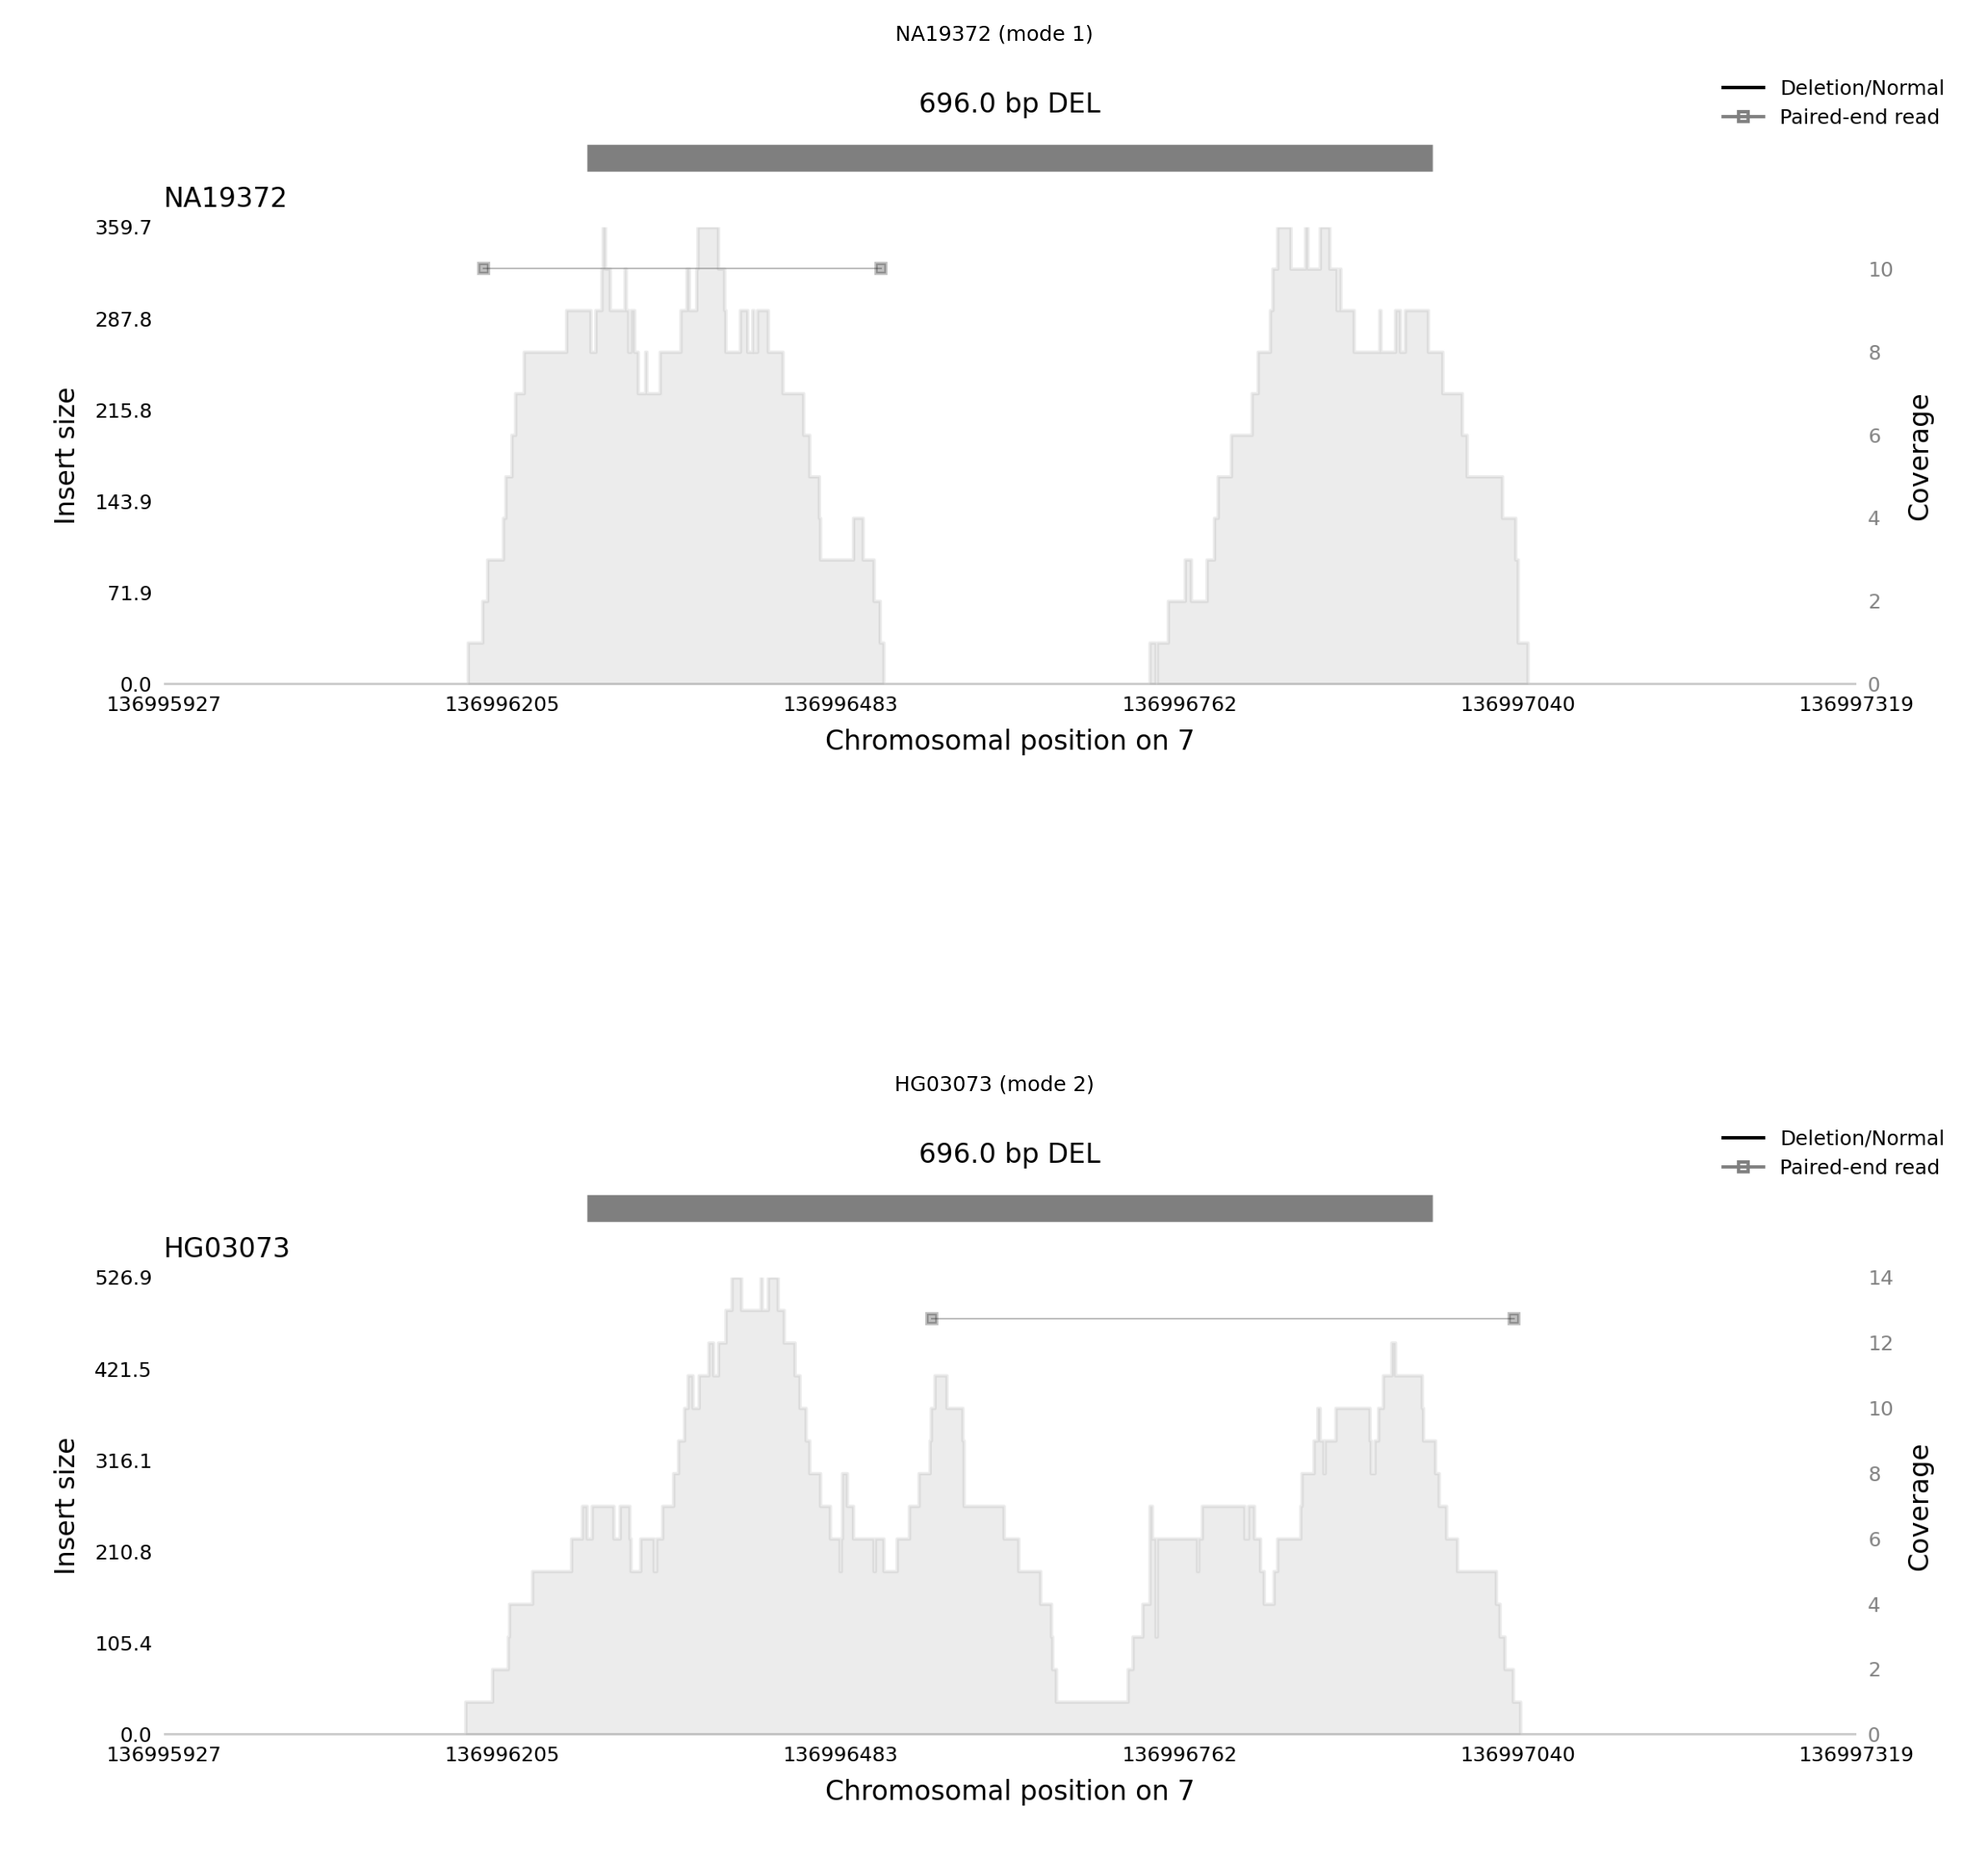

In [241]:
def varmodes2subplots(image_paths, titles, save = None):
    if len(image_paths) != len(titles):
        raise ValueError('number of images must match number of titles')
    
    images = [Image.open(x) for x in image_paths]

    fig = plt.figure(figsize=(10, 10), dpi=300)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(len(images), 1, i + 1)
        plt.imshow(img)
        plt.title(title, fontsize=6)
        plt.axis('off') 
    
    if save:
        plt.savefig(save)
    plt.close()
    return fig

# def varmodes2subplots(image_paths, titles):
#     if len(image_paths) != len(titles):
#         raise ValueError('number of images must match number of titles')
#     images = [Image.open(x) for x in image_paths]

#     plt.figure(figsize=(10, 10),dpi=300)
#     for i, (img, title) in enumerate(zip(images, titles)):
#         plt.subplot(1, len(images), i+1)
#         plt.imshow(img)
#         plt.title(title, fontsize =6)
#     return plt
fig = varmodes2subplots([df_samplot.iloc[0,:]['outfile'], df_samplot.iloc[1,:]['outfile']], ['NA19372 (mode 1)', 'HG03073 (mode 2)'],save='test.png')
fig

#### Plot randomly selected samples for different modes from the same variant

In [242]:
pngs = pd.DataFrame(df_samplot.bam.apply(lambda x: x.replace('.bam','.png')))
pngs['variant'] = pngs['bam'].apply(lambda x: os.path.basename(x).split('.')[0])
pngs['sample'] = pngs['bam'].apply(lambda x: os.path.basename(x).split('.')[2])
pngs['mode'] = pngs['bam'].apply(lambda x: os.path.basename(x).split('.')[1])
pngs.sort_values(['variant', 'mode'], inplace=True)
pngs.head()

,bam,variant,sample,mode
0,../data/variants/BI_GS_DEL1_B2_P0106_507/bam/B...,BI_GS_DEL1_B2_P0106_507,NA18645,mode_1
0,../data/variants/BI_GS_DEL1_B2_P0106_507/bam/B...,BI_GS_DEL1_B2_P0106_507,NA18988,mode_2
0,../data/variants/BI_GS_DEL1_B2_P0106_507/bam/B...,BI_GS_DEL1_B2_P0106_507,NA18574,mode_2
0,../data/variants/BI_GS_DEL1_B2_P0106_507/bam/B...,BI_GS_DEL1_B2_P0106_507,HG01841,mode_3
0,../data/variants/BI_GS_DEL1_B2_P0106_507/bam/B...,BI_GS_DEL1_B2_P0106_507,HG00704,mode_3


>1 mode found for variant DEL_pindel_24042
mode_1
mode_2


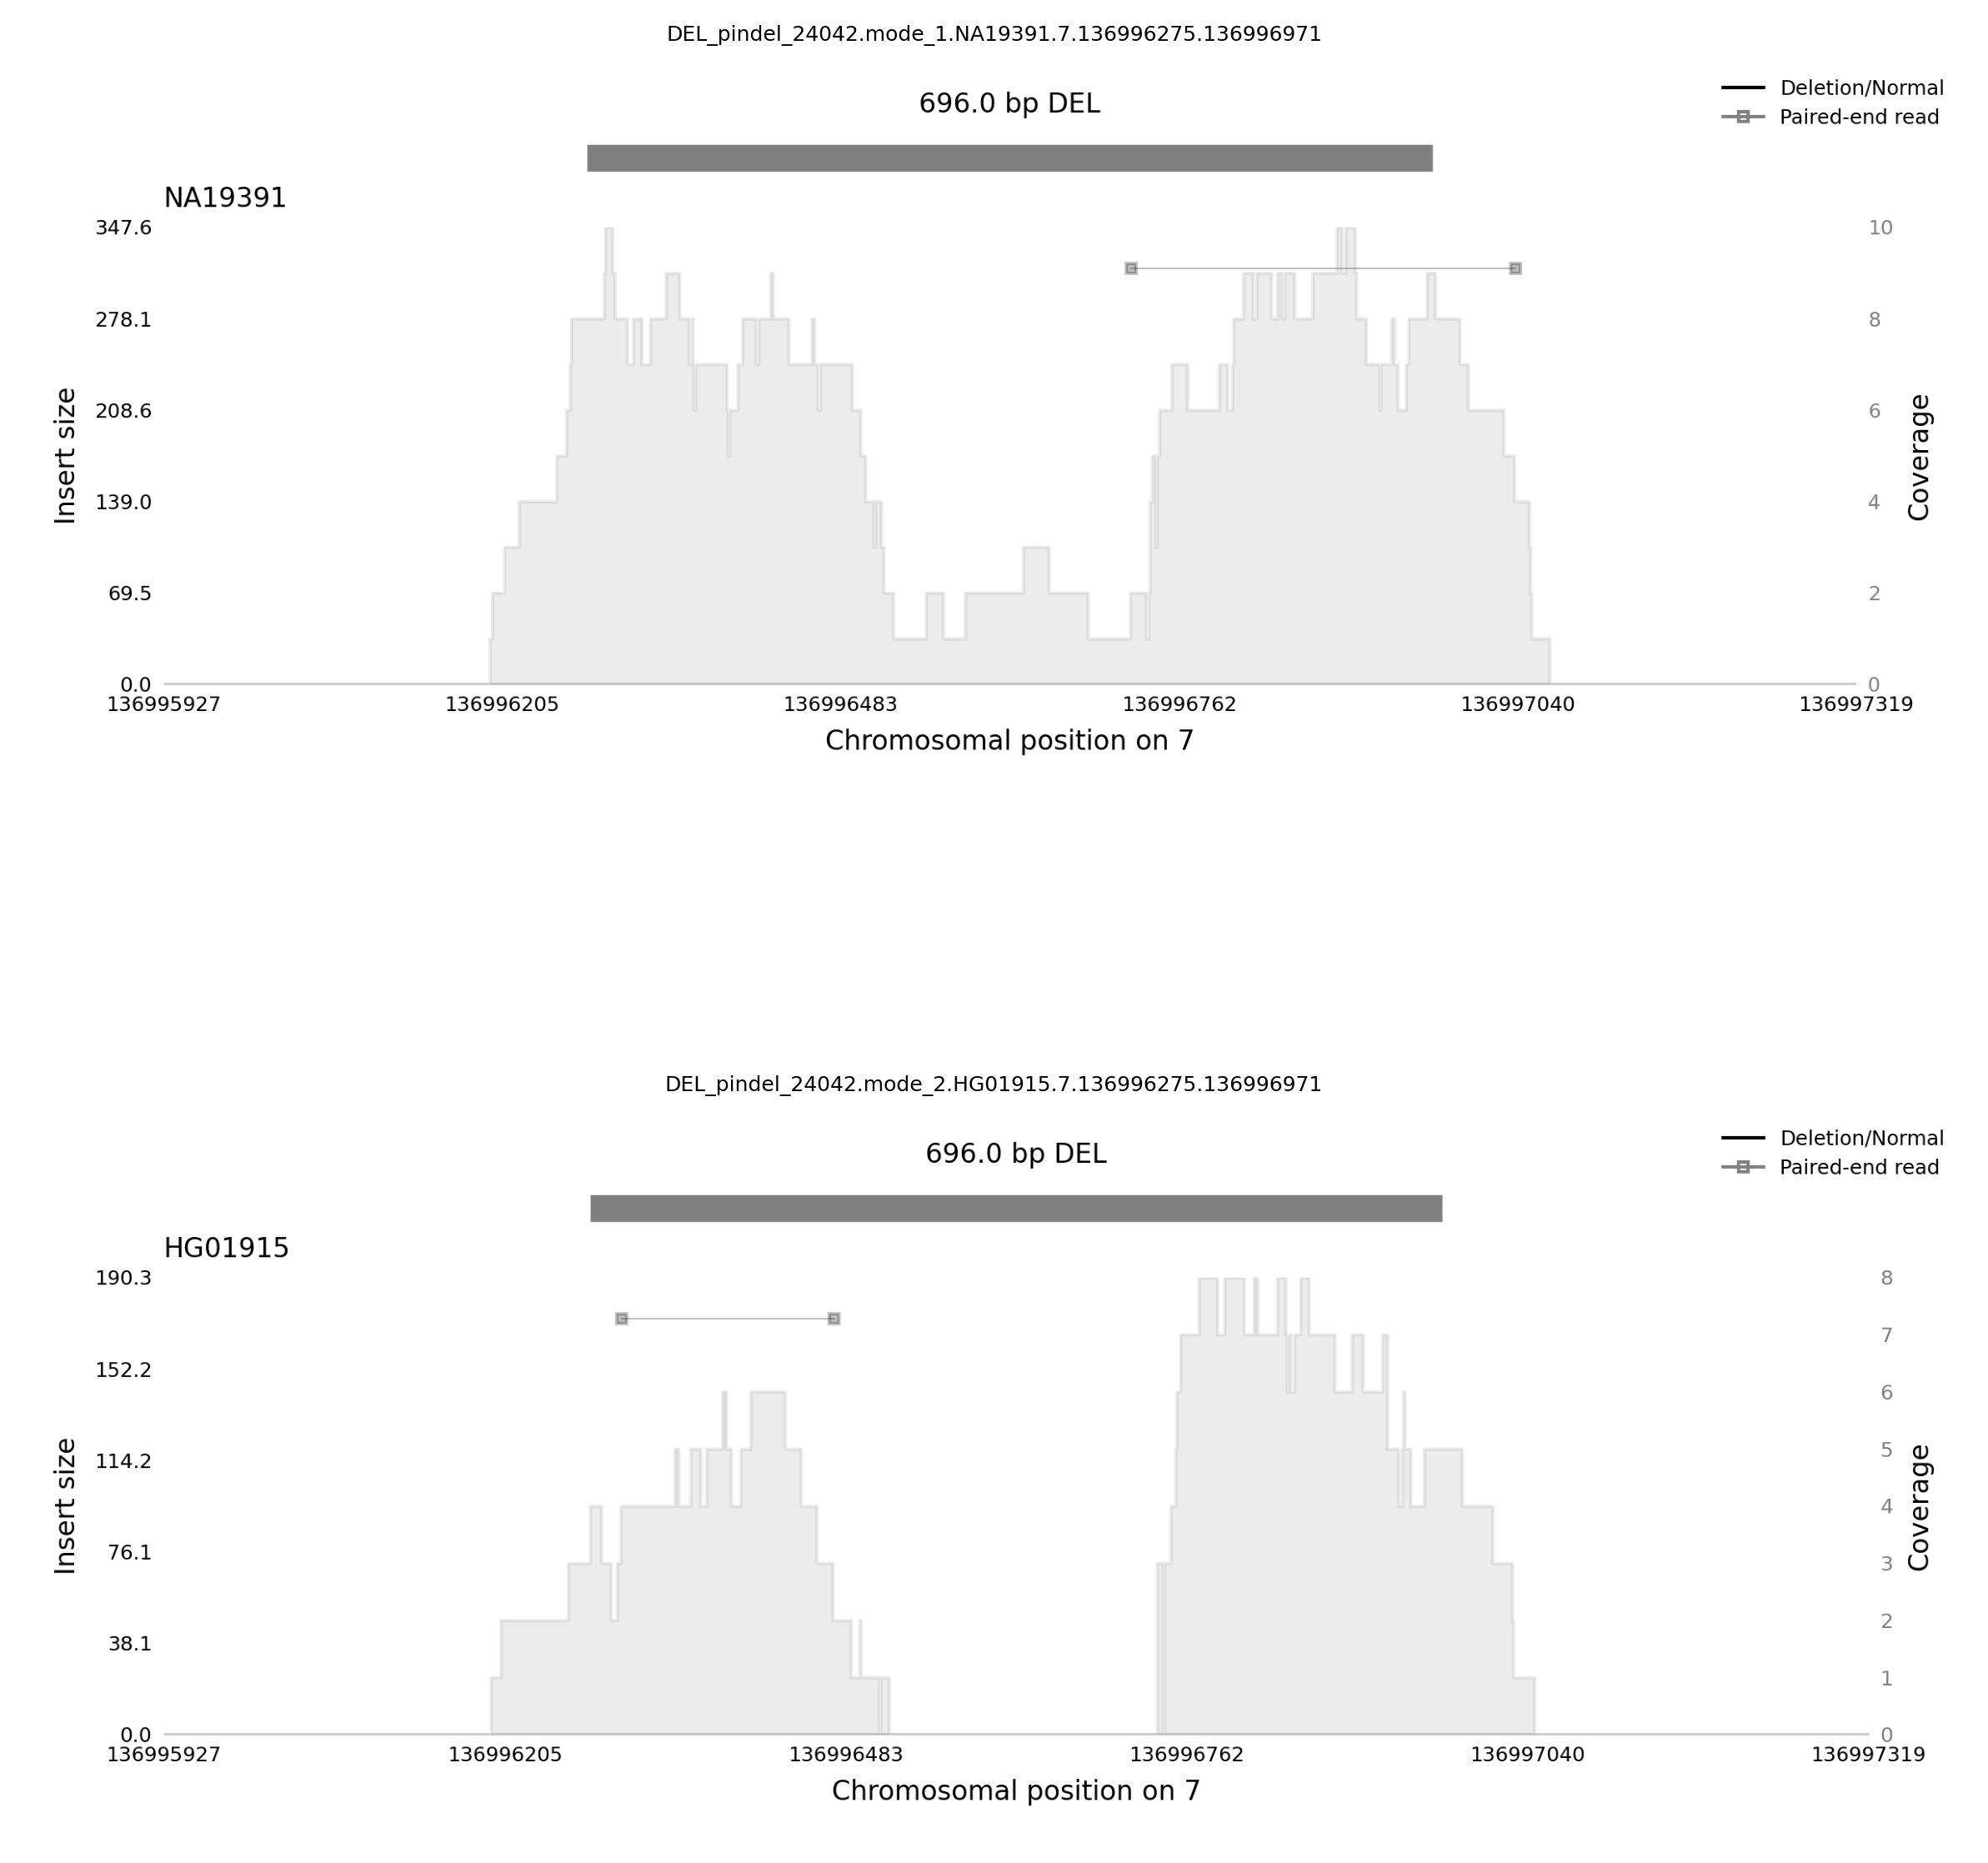

In [243]:
def random_samples(df_pngs, variant):
    df_pngs = df_pngs[df_pngs.variant == variant]
    groups = df_pngs.groupby('mode')
    if (len(groups) == 0):
        raise ValueError(f"No data found for variant {variant}")
    elif (len(groups)==1):
        print('warning: only one mode found for variant', variant)
    else:
        print('>1 mode found for variant', variant)
    random_paths = []
    titles = []
    for mode, df in groups:
        print(mode)
        rsample = df.sample(1)
        path = rsample['bam'].values[0]
        path = path.replace('bam','samplot')
        title = str(Path(os.path.basename(path)).stem)
        random_paths.append(path)
        titles.append(title)
    return random_paths, titles
paths, titles = random_samples(pngs, 'DEL_pindel_24042')
varmodes2subplots(paths, titles)

#    paired_images(pngs_var.iloc[0,:]['bam'], pngs_var.iloc[1,:]['bam'])

In [245]:
variant_l = pngs.variant.unique().tolist()
variant_l

['BI_GS_DEL1_B2_P0106_507',
 'BI_GS_DEL1_B2_P0114_484',
 'BI_GS_DEL1_B4_P2674_173',
 'DEL_pindel_24042',
 'DEL_pindel_47187',
 'SI_BD_10797',
 'UW_VH_10394',
 'UW_VH_19141',
 'UW_VH_9038']

In [248]:
dirpng='../fig'
figs = []
for v in variant_l:
    for _ in range(5):
        paths, titles = random_samples(pngs, v)
        outfile = os.path.join(dirpng,'-'.join(titles) + '.png')
        print(outfile)
        figs.append(varmodes2subplots(paths, titles, save = outfile))


>1 mode found for variant BI_GS_DEL1_B2_P0106_507
mode_1
mode_2
mode_3
../fig3/BI_GS_DEL1_B2_P0106_507.mode_1.NA18645.1.105821271.105855924-BI_GS_DEL1_B2_P0106_507.mode_2.NA18574.1.105821271.105855924-BI_GS_DEL1_B2_P0106_507.mode_3.NA18612.1.105821271.105855924.png
>1 mode found for variant BI_GS_DEL1_B2_P0106_507
mode_1
mode_2
mode_3
../fig3/BI_GS_DEL1_B2_P0106_507.mode_1.NA18645.1.105821271.105855924-BI_GS_DEL1_B2_P0106_507.mode_2.NA18574.1.105821271.105855924-BI_GS_DEL1_B2_P0106_507.mode_3.HG01841.1.105821271.105855924.png
>1 mode found for variant BI_GS_DEL1_B2_P0106_507
mode_1
mode_2
mode_3
../fig3/BI_GS_DEL1_B2_P0106_507.mode_1.NA18645.1.105821271.105855924-BI_GS_DEL1_B2_P0106_507.mode_2.NA18988.1.105821271.105855924-BI_GS_DEL1_B2_P0106_507.mode_3.NA18612.1.105821271.105855924.png
>1 mode found for variant BI_GS_DEL1_B2_P0106_507
mode_1
mode_2
mode_3
../fig3/BI_GS_DEL1_B2_P0106_507.mode_1.NA18645.1.105821271.105855924-BI_GS_DEL1_B2_P0106_507.mode_2.NA18988.1.105821271.105855924-B

#### Aggregate

In [249]:
from PIL import Image
import os

def pngs_to_pdf(png_files, output_pdf):
    # Open the first image and convert it to RGB (necessary for saving as PDF)
    first_image = Image.open(png_files[0]).convert('RGB')
    
    # Create a list for the rest of the images
    images = []
    
    # Loop through the remaining PNG files
    for png_file in png_files[1:]:
        img = Image.open(png_file).convert('RGB')
        images.append(img)

    # Save all images as a single PDF
    first_image.save(output_pdf, save_all=True, append_images=images)

# Example usage
output_pdf = 'all.pdf'  # Desired output PDF file name

pngs_to_pdf([os.path.join(dirpng, x) for x in os.listdir(dirpng)], output_pdf)